In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

from trustee import ClassificationTrustee

In [2]:
attacker_ips = {
    '169.231.210.93',
    '169.231.28.232',
    '169.231.123.195',
    '169.231.172.165',
    '169.231.11.193',
    '169.231.8.190',
    '169.231.10.199',
}

In [3]:
campus_dataset = pd.read_csv('campus_cicfeatures_1.csv')
campus_dataset['Class'] = 0
campus_dataset.loc[campus_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1

print(len(campus_dataset))
ttl_data = pd.read_csv('campus_ttl_1.csv')
campus_dataset = campus_dataset.merge(ttl_data, on="Flow ID", how='left')
len(campus_dataset)
campus_dataset.to_csv('campus_dataset.csv')

6681


In [4]:
campus_dataset = campus_dataset.drop([
    'Flow ID',
    'Src IP',
    'Dst IP',
    'Timestamp', 
    'Protocol',    # always tcp
    'Label',       # empty
], axis=1)

In [5]:
azure_dataset = pd.read_csv('azure_cicfeatures_1.csv')
azure_dataset['Class'] = 0
azure_dataset.loc[azure_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_azure = pd.read_csv('azure_ttl_1.csv')
azure_dataset = azure_dataset.merge(ttl_df_azure, on="Flow ID", how='left')
azure_dataset = azure_dataset.replace([np.inf, -np.inf], np.nan)
azure_dataset = azure_dataset.dropna(axis=0)
azure_dataset.to_csv('azure_dataset.csv')

In [6]:
attacker_ips = {
    '157.245.108.149',
    '34.214.149.122',
}

multicloud_dataset = pd.read_csv('multicloud_cicfeatures_1.csv')
multicloud_dataset['Class'] = 0
multicloud_dataset.loc[multicloud_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_multicloud = pd.read_csv('multicloud_ttl_1.csv')
multicloud_dataset = multicloud_dataset.merge(ttl_df_multicloud, on="Flow ID", how='left')
multicloud_dataset = multicloud_dataset.replace([np.inf, -np.inf], np.nan)
multicloud_dataset = multicloud_dataset.dropna(axis=0)
multicloud_dataset.to_csv('multicloud_dataset.csv')

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
from pytorch_tabnet.tab_model import TabNetClassifier

Train on campus dataset, check on Azure, multicloud, and CIC-18

In [9]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features]
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [10]:
from sklearn.preprocessing import StandardScaler
x_train_scaler = StandardScaler()
x_test_scaler = StandardScaler()
x_test_2_scaler = StandardScaler()

x_train = pd.DataFrame(x_train_scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(x_test_scaler.fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(x_test_2_scaler.fit_transform(x_test_2), columns = x_test_2.columns)

In [11]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    TabNetClassifier(verbose=0),
]

In [12]:
for clf in classifiers:
    print(clf)
    clf.fit(x_train.values, y_train.values)
    y_pred = clf.predict(x_train.values)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       528
           1       0.11      0.11      0.11       307

    accuracy                           0.36       835
   macro avg       0.30      0.31      0.30       835
weighted avg       0.35      0.36      0.36       835

[[267 261]
 [274  33]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.84      0.29       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       528
           1       0.00      0.00      0.00       307

    accuracy                           0.38       835
   macro avg       0.26      0.30      0.28       835
weighted avg       0.32      0.38      0.35       835

[[321 207]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      5547
           1       0.17      0.81      0.28       638

    accuracy                           0.58      6185
   ma

Let's explore the reasons of this performance

campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.27      0.22      0.24       528
           1       0.00      0.00      0.00       307

    accuracy                           0.14       835
   macro avg       0.14      0.11      0.12       835
weighted avg       0.17      0.14      0.15       835

[[114 414]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.49      6185
   ma

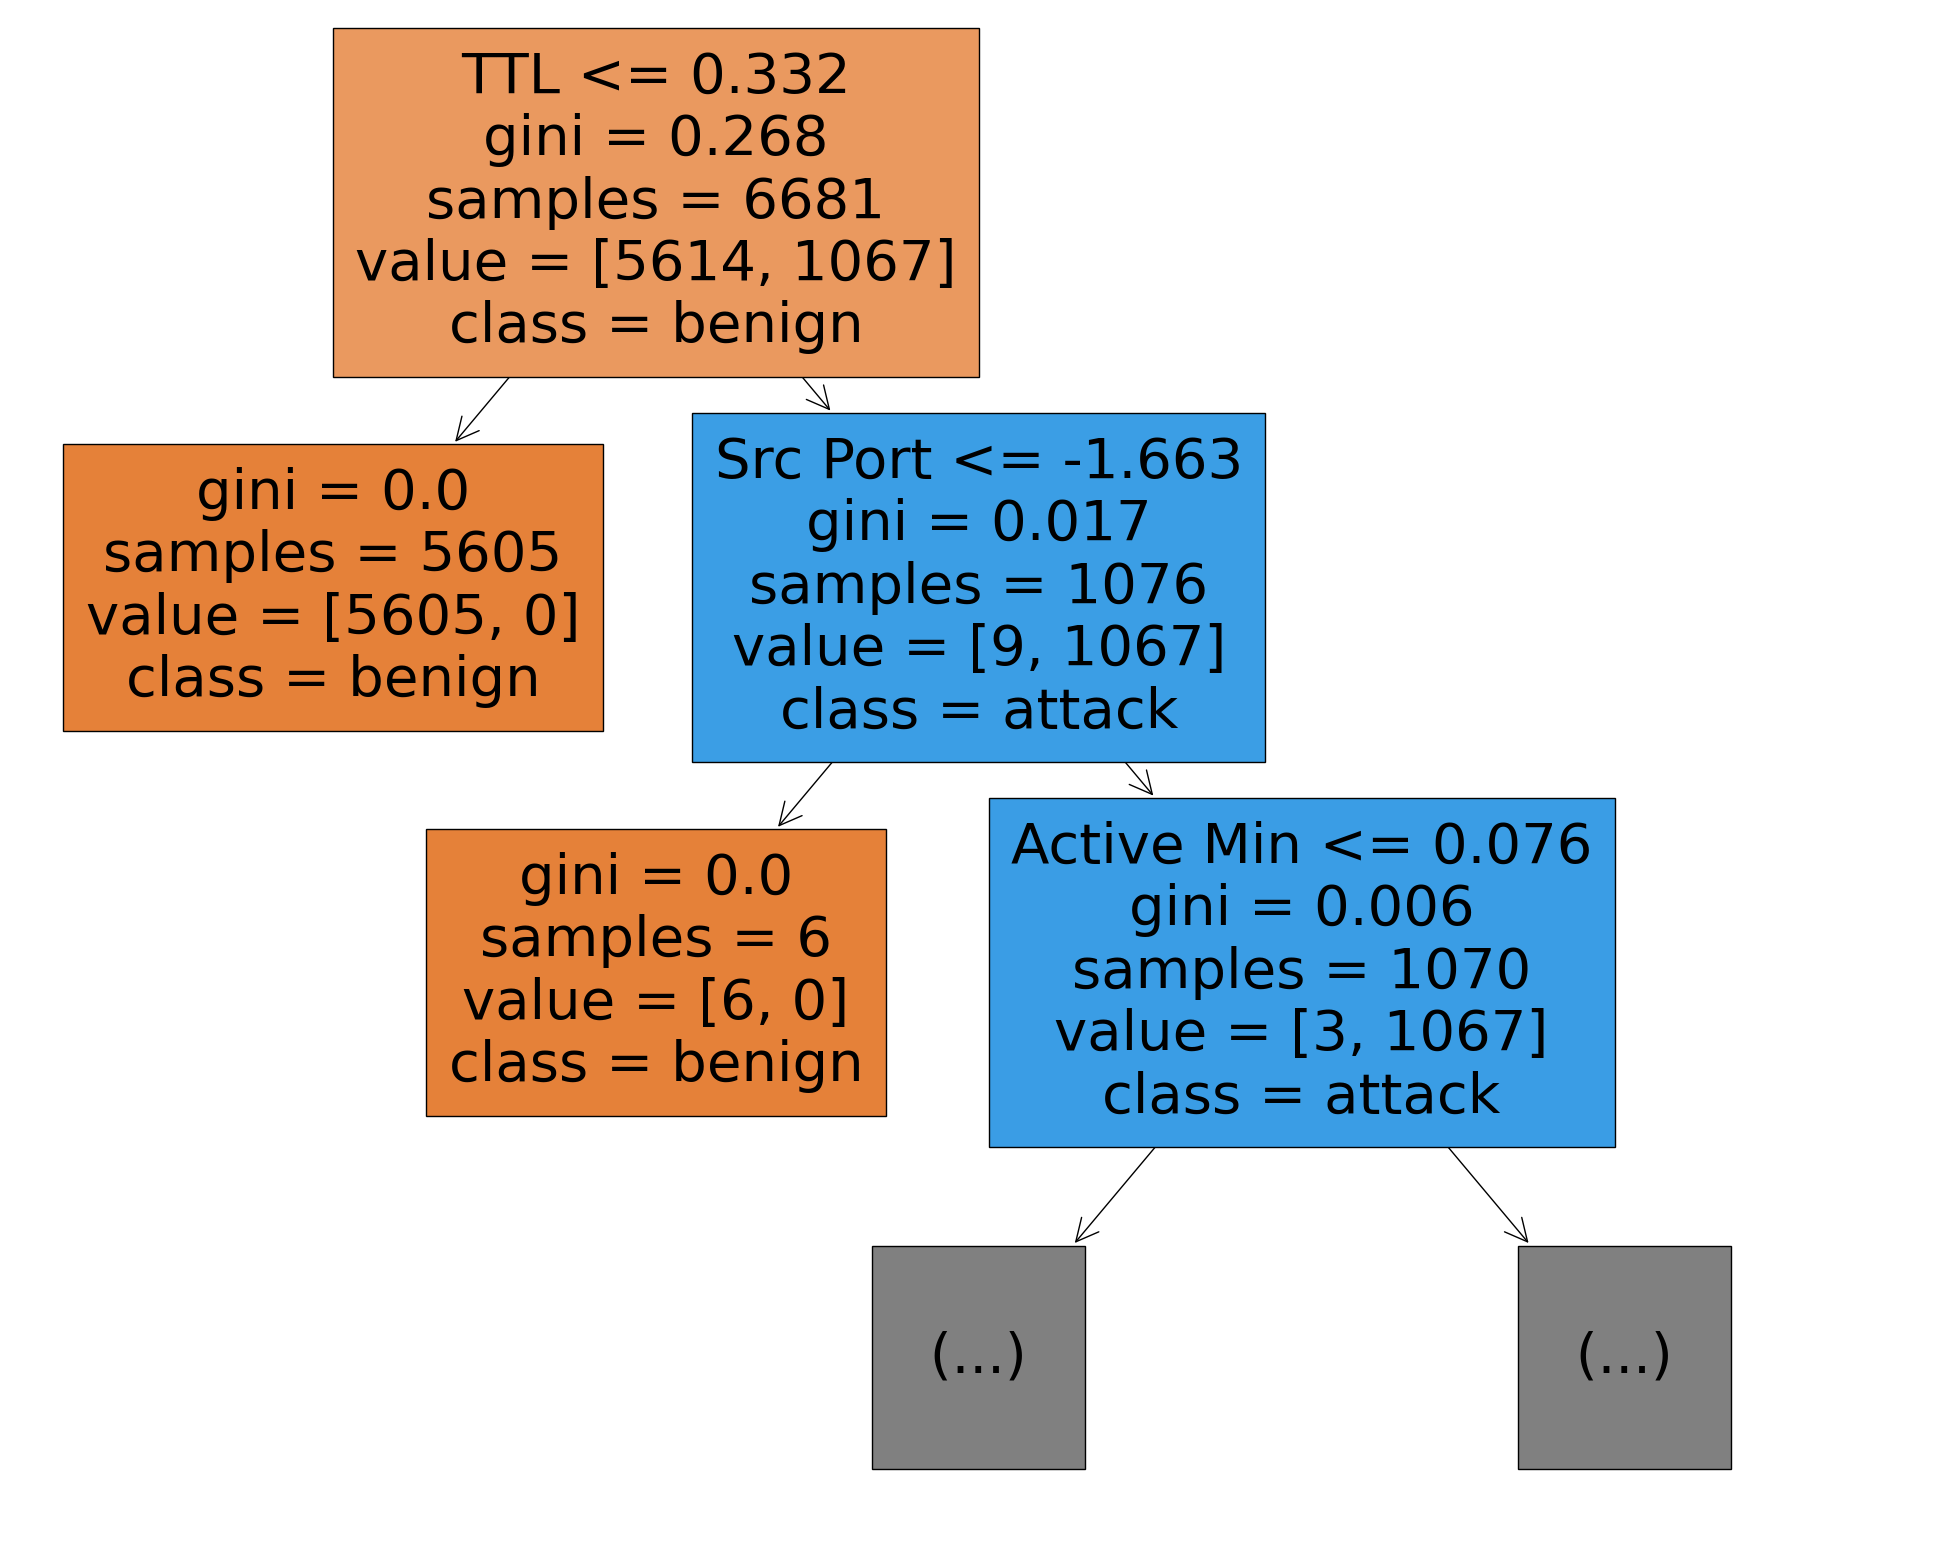

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_train)
print("campus dataset training accuracy: ")
print(metrics.classification_report(y_train, y_pred))

y_pred = clf.predict(x_test)
print("Azure dataset test accuracy: ")
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

y_pred = clf.predict(x_test_2)
print("Multicloud dataset test accuracy: ")
print(metrics.classification_report(y_test_2, y_pred))
print(metrics.confusion_matrix(y_test_2, y_pred))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=2)

The answer is a shortcut in the dataset - usage of TTL as a feature.  
Random forests choose features randomly and therefore often remove TTL from the list and doesn't overfit to it.  

Anyway, TTL is a plain shortcut, let's remove it.

## Out of curiosity - dropping or noising the features
Use information from the future - we know that TTL and Init Win Bytes are or would be shortcuts, so let's add some noise there or drop them and check performance.

In [14]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [15]:
x_train.loc[:, 'TTL'] += np.random.randint(-1, 1, [len(x_train)])
x_train.loc[:, 'Bwd Init Win Bytes'] += np.random.randint(-5, 5, [len(x_train)])

In [17]:
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)

In [18]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    TabNetClassifier(verbose=0),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train.values, y_train.values)
    y_pred = clf.predict(x_train.values)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       528
           1       0.47      0.77      0.59       307

    accuracy                           0.60       835
   macro avg       0.63      0.64      0.60       835
weighted avg       0.67      0.60      0.60       835

[[267 261]
 [ 72 235]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.87      0.30       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       0.99      1.00      0.99      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.46      0.49      0.48       528
           1       0.00      0.00      0.00       307

    accuracy                           0.31       835
   macro avg       0.23      0.25      0.24       835
weighted avg       0.29      0.31      0.30       835

[[261 267]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      5547
           1       0.17      0.83      0.29       638

    accuracy                           0.58      6185
   ma

### Or let's just drop them

In [19]:
x_train = x_train.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test = x_test.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test_2 = x_test_2.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)

In [20]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
    TabNetClassifier(verbose=0),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train.values, y_train.values)
    y_pred = clf.predict(x_train.values)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       0.99      0.79      0.88      1067

    accuracy                           0.96      6681
   macro avg       0.98      0.89      0.93      6681
weighted avg       0.97      0.96      0.96      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       528
           1       0.94      0.94      0.94       307

    accuracy                           0.95       835
   macro avg       0.95      0.95      0.95       835
weighted avg       0.95      0.95      0.95       835

[[508  20]
 [ 18 289]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      5547
           1       0.45      0.97      0.61       638

    accuracy                           0.87

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       0.99      0.77      0.87      1067

    accuracy                           0.96      6681
   macro avg       0.97      0.89      0.92      6681
weighted avg       0.96      0.96      0.96      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       528
           1       1.00      0.86      0.92       307

    accuracy                           0.95       835
   macro avg       0.96      0.93      0.94       835
weighted avg       0.95      0.95      0.95       835

[[527   1]
 [ 42 265]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5547
           1       0.40      0.90      0.55       638

    accuracy                           0.85      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/mini

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.63      0.97      0.76       526
           1       0.35      0.03      0.05       309

    accuracy                           0.62       835
   macro avg       0.49      0.50      0.41       835
weighted avg       0.52      0.62      0.50       835

Model explanation score report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.78       528
           1       0.65      0.06      0.10       307

    accuracy                           0.64       835
   macro avg       0.65      0.52      0.44       835
weighted avg       0.65      0.64      0.53       835



[Text(0.6, 0.8333333333333334, 'Fwd Packet Length Mean <= 0.942\ngini = 0.234\nsamples = 2618\nvalue = [2264, 354]\nclass = benign'),
 Text(0.4, 0.5, 'RST Flag Count <= 2.133\ngini = 0.108\nsamples = 2399\nvalue = [2262, 137]\nclass = benign'),
 Text(0.2, 0.16666666666666666, 'gini = 0.002\nsamples = 2263\nvalue = [2261, 2]\nclass = benign'),
 Text(0.6, 0.16666666666666666, 'gini = 0.015\nsamples = 136\nvalue = [1, 135]\nclass = attack'),
 Text(0.8, 0.5, 'gini = 0.018\nsamples = 219\nvalue = [2, 217]\nclass = attack')]

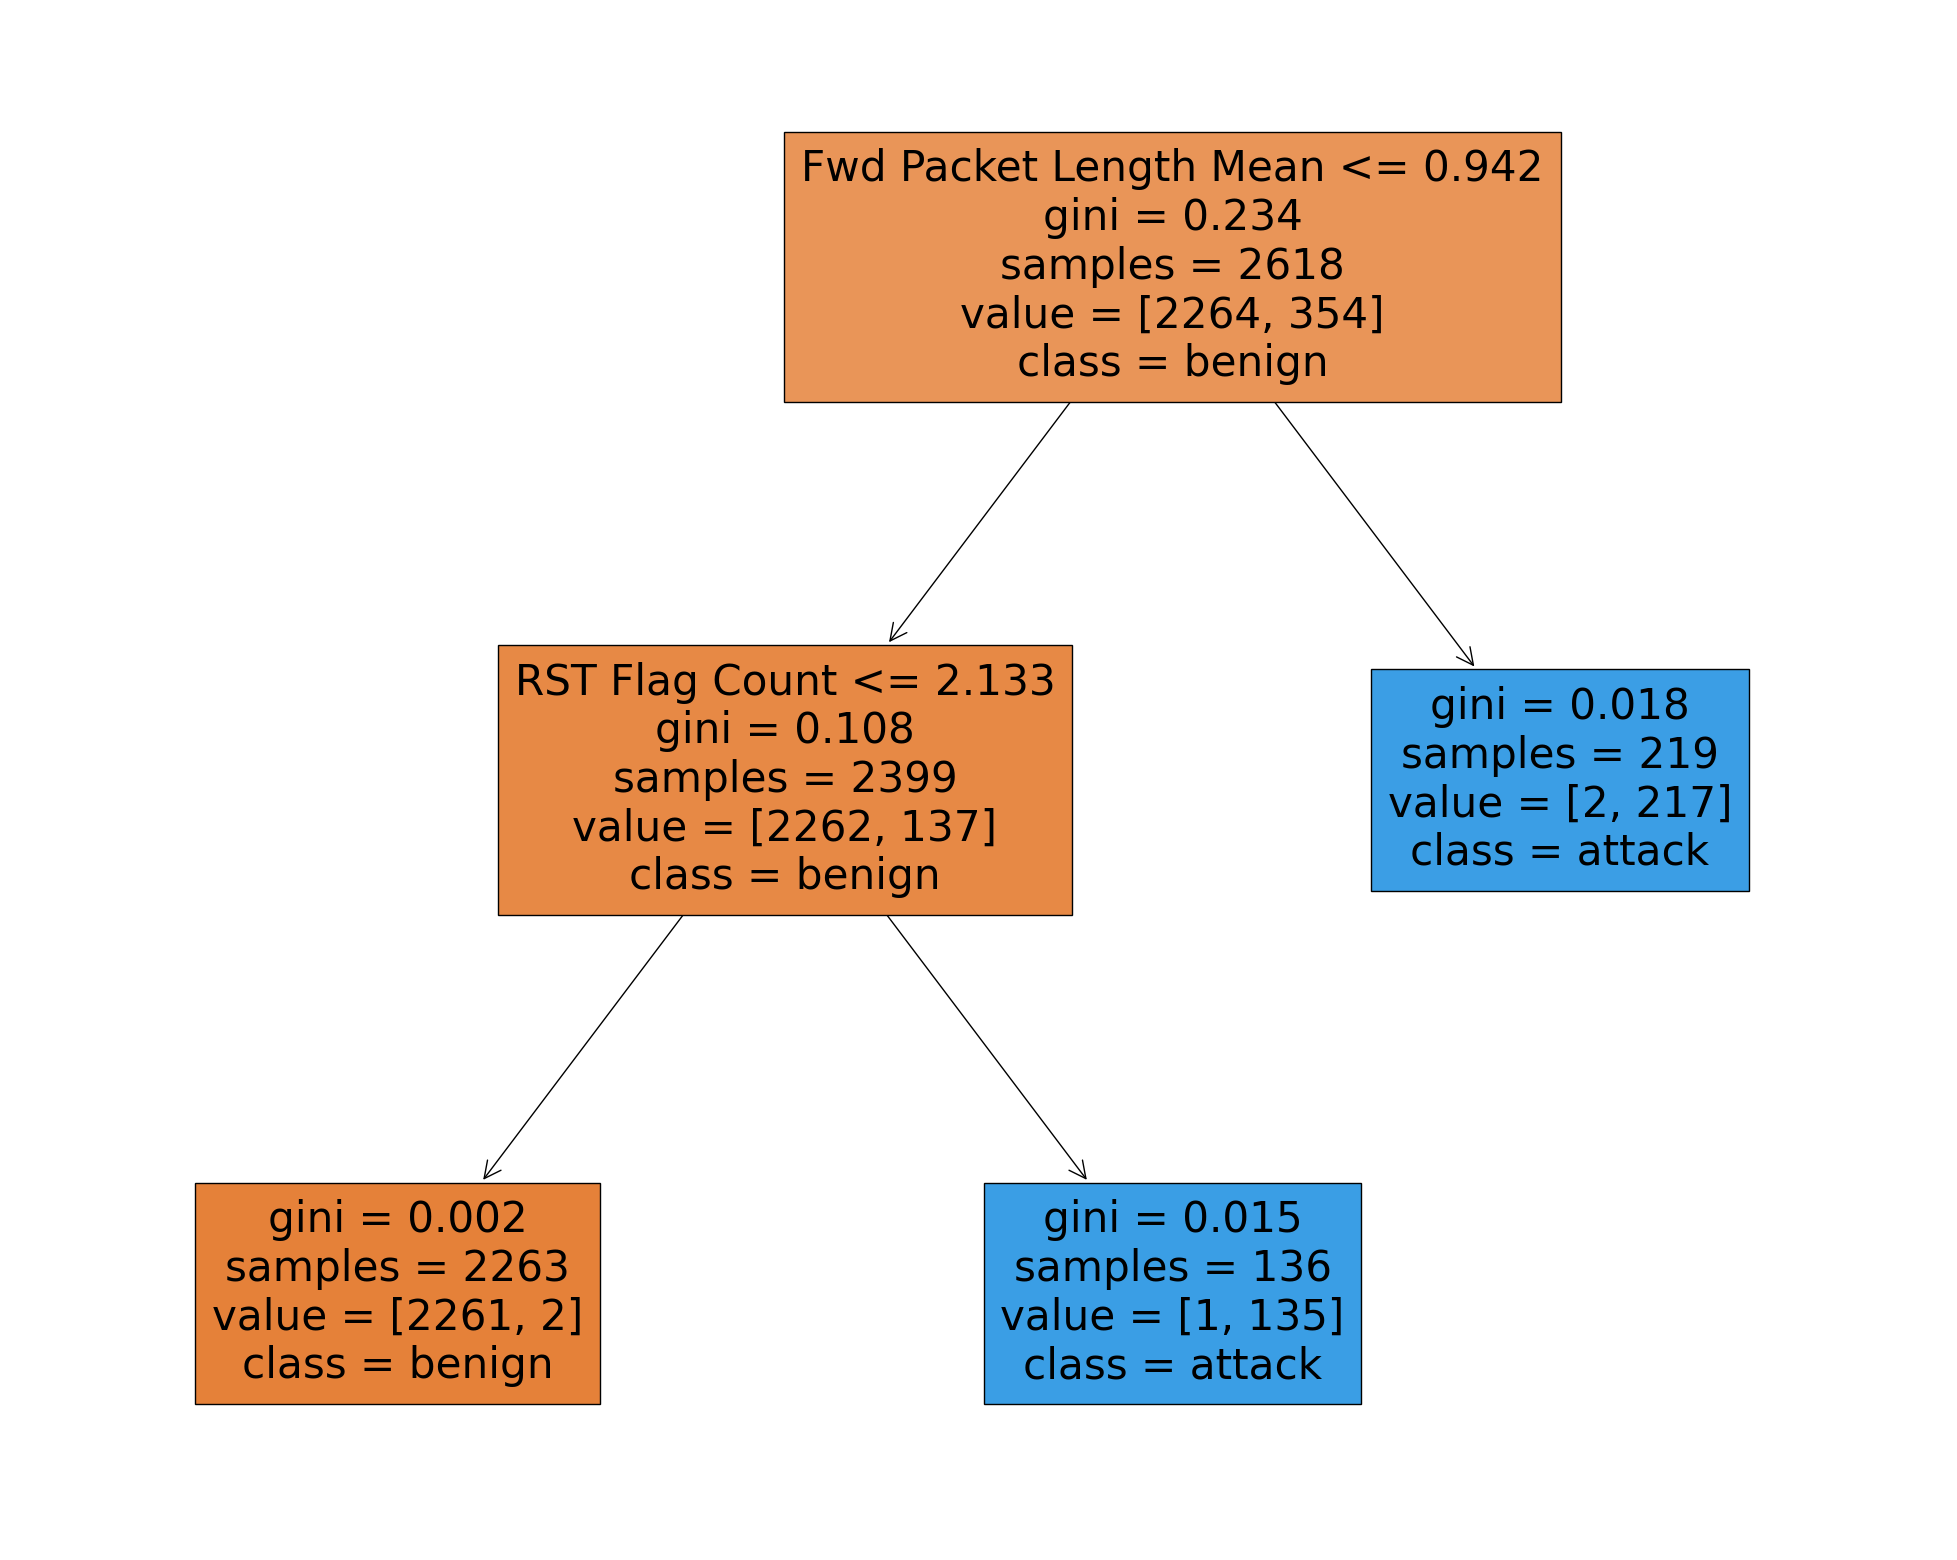

In [21]:
trustee = ClassificationTrustee(expert=classifiers[0])
trustee.fit(x_train, y_train, num_iter=10, num_stability_iter=3, samples_size=0.8)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_test)

print("Model explanation global fidelity report:")
print(metrics.classification_report(classifiers[0].predict(x_test), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_test, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)

### Checking SMOTE

In [22]:
import smote_variants as sv

In [23]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [24]:
from sklearn.preprocessing import StandardScaler

x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)

In [26]:
oversampler = sv.SMOTE()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
    TabNetClassifier(verbose=0),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

2023-08-04 11:37:18,955:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-08-04 11:37:18,956:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-08-04 11:37:18,957:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-08-04 11:37:19,047:INFO:SMOTE: simplex sampling with n_dim 2


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       528
           1       0.14      0.13      0.13       307

    accuracy                           0.37       835
   macro avg       0.32      0.32      0.32       835
weighted avg       0.37      0.37      0.37       835

[[267 261]
 [266  41]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.17      0.83      0.29       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      5614
           1       1.00      0.49      0.66      5614

    accuracy                           0.75     11228
   macro avg       0.83      0.75      0.73     11228
weighted avg       0.83      0.75      0.73     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.37      0.34      0.36       528
           1       0.00      0.00      0.00       307

    accuracy                           0.22       835
   macro avg       0.19      0.17      0.18       835
weighted avg       0.24      0.22      0.23       835

[[182 346]
 [306   1]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.49      6185
   ma

### SYMPROD SMOTE

In [27]:
oversampler = sv.SYMPROD()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
    TabNetClassifier(verbose=0),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

2023-08-04 11:37:51,197:INFO:SYMPROD: Running sampling via ('SYMPROD', "{'proportion': 1.0, 'std_outliers': 3, 'k_neighbors': 7, 'm_neighbors': 7, 'cutoff_threshold': 1.25, 'nn_params': {}, 'random_state': None, 'class_name': 'SYMPROD'}")
2023-08-04 11:37:51,208:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-08-04 11:37:51,210:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-08-04 11:37:52,724:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-08-04 11:37:52,725:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-08-04 11:37:52,926:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-08-04 11:37:52,927:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-08-04 11:37:52,987:INFO:SYMPROD: Cutoff value updated from 1.250000 to 1.250000
2023-08-04 11:37:52,988:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-08-04 11:37:52,98

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       528
           1       0.10      0.09      0.09       307

    accuracy                           0.35       835
   macro avg       0.29      0.30      0.30       835
weighted avg       0.34      0.35      0.35       835

[[267 261]
 [279  28]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.84      0.29       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.71      0.16      0.26       528
           1       0.38      0.89      0.53       307

    accuracy                           0.43       835
   macro avg       0.55      0.53      0.40       835
weighted avg       0.59      0.43      0.36       835

[[ 85 443]
 [ 34 273]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.28      0.43      5547
           1       0.13      0.92      0.23       638

    accuracy                           0.35      6185
   ma

### CCR

In [28]:
oversampler = sv.CCR()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
    TabNetClassifier(verbose=0),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test.values)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2.values)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))

2023-08-04 11:41:15,101:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1.0, 'energy': 1.0, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None, 'class_name': 'CCR'}")


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.56      0.20      0.30       528
           1       0.35      0.73      0.47       307

    accuracy                           0.40       835
   macro avg       0.46      0.47      0.38       835
weighted avg       0.48      0.40      0.36       835

[[106 422]
 [ 82 225]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      5547
           1       0.19      0.91      0.31       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.57      0.01      0.01       528
           1       0.37      0.99      0.54       307

    accuracy                           0.37       835
   macro avg       0.47      0.50      0.28       835
weighted avg       0.50      0.37      0.21       835

[[  4 524]
 [  3 304]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.17      0.84      0.29       638

    accuracy                           0.58      6185
   ma